In [1]:
# Import dependencies
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import inspect
import config
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

### Extract CSVs into Dataframe

In [2]:
movies_file = "Resources/movies.csv"
movies_df = pd.read_csv(movies_file)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings_file = "Resources/ratings.csv"
ratings_df = pd.read_csv(ratings_file)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Transform movies Dataframe

In [4]:
# Create a filtered dataframe from specific columns
movies_cols = ["movieId","title","genres"]
movies_transformed = movies_df[movies_cols].copy()

# Rename the column headers
movies_transformed= movies_transformed.rename(columns={
                                                          "movieId": "movie_id"
                                                          })

# Clean the data by dropping duplicates and NA values and setting the index
movies_transformed.drop_duplicates("movie_id", inplace=True)
movies_transformed.head()

,movie_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Transform ratings Dataframe

In [5]:
# Create a filtered dataframe from specific columns
ratings_cols = ["userId","movieId","rating","timestamp"]
ratings_transformed = ratings_df[ratings_cols].copy()

# Rename the column headers
ratings_transformed= ratings_transformed.rename(columns={
                                                          "movieId": "movie_id",
                                                          "userId" : "user_id",
                                                          "timestamp" : "timestamps"
                                                          })

# Clean the data by dropping duplicates and NA values and setting the index
ratings_transformed.drop_duplicates(subset=["user_id","movie_id"], inplace=True)
ratings_transformed.head()

,user_id,movie_id,rating,timestamps
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Connect to Local Database

In [6]:
protocol = 'postgresql'
username = config.Username
password = config.Password
host = 'localhost'
port = 5432
database_name = 'movies_db'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)
insp = inspect(engine)

### Inspect Tables

In [7]:
insp.get_table_names()

['movies', 'ratings']

### Load

In [8]:
movies_transformed.to_sql(name='movies', con=engine, if_exists='replace', index=False)

742

In [9]:
ratings_transformed.to_sql(name='ratings', con=engine, if_exists='replace', index=False)

836

### Confirm data has been added by querying the movies table

In [10]:
pd.read_sql_query('select * from movies', con=engine).head()

,movie_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Confirm data has been added by querying the ratings table

In [11]:
pd.read_sql_query('select * from ratings', con=engine).head()

,user_id,movie_id,rating,timestamps
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Join Data from movies and ratings

In [12]:
sql_join = r"""SELECT movies.movie_id, movies.title, movies.genres, ratings.user_id, ratings.rating, ratings.timestamps
FROM movies
INNER JOIN ratings
ON movies.movie_id=ratings.movie_id;"""
data_df=pd.read_sql_query(sql_join, con=engine)

In [13]:
# Choose a cutoff value and create a list of application types to be replaced
data_df0=data_df.copy()
data_df0['rating'] = np.where(data_df0['rating'] < 4, 0,1)
#Check that the transformation worked
data_df0


,movie_id,title,genres,user_id,rating,timestamps
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,214,0,853937855
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,213,0,1316196157
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,153,0,1525548642
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,89,0,1520408314
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,233,0,1524781249
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,1,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,0,1537109545
100833,193585,Flint (2017),Drama,184,0,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,0,1537110021


In [14]:
# Look at movie value counts for cleanup
review_count = data_df['movie_id'].value_counts()
review_count

356       329
318       317
296       307
593       279
2571      278
         ... 
4093        1
4089        1
58351       1
4083        1
193609      1
Name: movie_id, Length: 9724, dtype: int64

In [15]:
# Choose a cutoff value and create a list of movies to be excluded
movies_to_exclude = list(review_count[review_count < 10].index)
# Remove from dataframe
data_df = data_df[~data_df['movie_id'].isin(movies_to_exclude)]
# Check to make sure cleaning was successful
data_df['movie_id'].value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
5329       10
5296       10
68793      10
102481     10
45668      10
Name: movie_id, Length: 2269, dtype: int64

In [16]:
# Check remaining ratings
data_df

,movie_id,title,genres,user_id,rating,timestamps
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,214,3.0,853937855
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,213,3.5,1316196157
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,153,2.0,1525548642
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,89,3.0,1520408314
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,233,3.0,1524781249
...,...,...,...,...,...,...
100792,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,249,5.0,1531611534
100793,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,248,4.5,1534599909
100794,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,25,5.0,1535470534
100795,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,98,5.0,1532457913


In [17]:
# Split our preprocessed data into our features and target arrays
y = data_df0["rating"]
X = data_df0.drop(["rating","title","genres"],axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [18]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler() model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)

In [19]:
# Transform the training and testing data by using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 1, Train/Test Score: 1.000/0.619
k: 3, Train/Test Score: 0.804/0.638
k: 5, Train/Test Score: 0.760/0.647
k: 7, Train/Test Score: 0.738/0.651
k: 9, Train/Test Score: 0.726/0.653
k: 11, Train/Test Score: 0.717/0.652
k: 13, Train/Test Score: 0.709/0.652
k: 15, Train/Test Score: 0.704/0.652
k: 17, Train/Test Score: 0.700/0.653
k: 19, Train/Test Score: 0.696/0.652


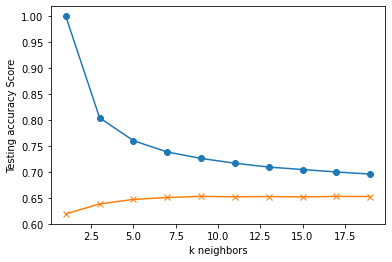

In [20]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [21]:
# Note that k: 3 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
print('k=3 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=3 Test Acc: 0.638


### Data Model Optmisation 1

In [22]:
# Choose a cutoff value and create a list of application types to be replaced
data_df1=data_df.copy()
data_df1['rating'] = np.where(data_df1['rating'] < 3, 0,1)
#Check that the transformation worked
data_df1


,movie_id,title,genres,user_id,rating,timestamps
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,214,1,853937855
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,213,1,1316196157
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,153,0,1525548642
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,89,1,1520408314
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,233,1,1524781249
...,...,...,...,...,...,...
100792,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,249,1,1531611534
100793,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,248,1,1534599909
100794,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,25,1,1535470534
100795,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,98,1,1532457913


In [23]:
# Split our preprocessed data into our features and target arrays
y = data_df1["rating"]
X = data_df1.drop(["rating","title","genres"],axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [24]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler() model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)

In [25]:
# Transform the training and testing data by using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 1, Train/Test Score: 1.000/0.773
k: 3, Train/Test Score: 0.886/0.807
k: 5, Train/Test Score: 0.866/0.821
k: 7, Train/Test Score: 0.856/0.826
k: 9, Train/Test Score: 0.852/0.829
k: 11, Train/Test Score: 0.849/0.831
k: 13, Train/Test Score: 0.847/0.834
k: 15, Train/Test Score: 0.845/0.836
k: 17, Train/Test Score: 0.845/0.837
k: 19, Train/Test Score: 0.843/0.837


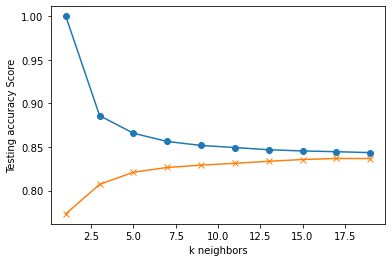

In [26]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [27]:
# Note that k: 3 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
print('k=3 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=3 Test Acc: 0.807


### Data Model Optimisation 2

In [28]:
# Choose a cutoff value and create a list of application types to be replaced
data_df2=data_df.copy()
data_df2['rating'] = np.where(data_df2['rating'] < 2.5, 0,1)
#Check that the transformation worked
data_df2


,movie_id,title,genres,user_id,rating,timestamps
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,214,1,853937855
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,213,1,1316196157
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,153,0,1525548642
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,89,1,1520408314
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,233,1,1524781249
...,...,...,...,...,...,...
100792,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,249,1,1531611534
100793,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,248,1,1534599909
100794,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,25,1,1535470534
100795,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,98,1,1532457913


In [29]:
# Split our preprocessed data into our features and target arrays
y = data_df2["rating"]
X = data_df2.drop(["rating","title","genres"],axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [30]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler() model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)

In [31]:
# Transform the training and testing data by using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 1, Train/Test Score: 1.000/0.828
k: 3, Train/Test Score: 0.913/0.859
k: 5, Train/Test Score: 0.899/0.873
k: 7, Train/Test Score: 0.893/0.878
k: 9, Train/Test Score: 0.891/0.880
k: 11, Train/Test Score: 0.889/0.882
k: 13, Train/Test Score: 0.888/0.884
k: 15, Train/Test Score: 0.888/0.883
k: 17, Train/Test Score: 0.887/0.884
k: 19, Train/Test Score: 0.887/0.885


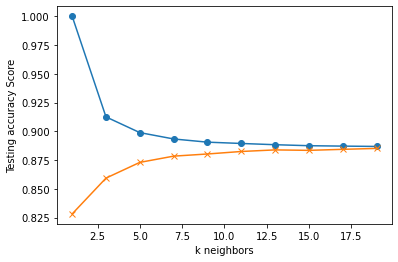

In [32]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [33]:
# Note that k: 3 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
print('k=3 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=3 Test Acc: 0.859
